In [1]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys
import time

from collections import defaultdict

from blackjack import BlackjackEnv
import plotting

matplotlib.style.use('ggplot')

In [2]:
env = BlackjackEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action . float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    def policy_fn(observation):
        pi = np.ones(nA) * epsilon / nA
        
        actions = Q[observation]
        idx = np.arange(nA)[actions == np.amax(actions)]
        pi[np.random.choice(idx)] += 1 - epsilon
        
#         pi[np.argmax(Q[observation])] += 1 - epsilon
        return pi
    
    return policy_fn

In [11]:
def performance(title, rewards):
    print(title)
    print("mean: ", np.mean(rewards))
    print("min: ", np.min(rewards))
    print("max: ", np.max(rewards))
    print("std: ", np.std(rewards))

In [137]:
def mc_control_epsilon_greedy(env, num_episodes, discount_factor=1.0, epsilon=1):
    """
    Monte Carlo Control using Epsilon-Greedy policies.
    Finds an optimal epsilon-greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        discount_factor: Gamma discount factor.
        epsilon: Chance the sample a random action. Float betwen 0 and 1.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities
    """
    schedule = dict()
    schedule[1] = lambda i, n : (n - i) / n
    schedule[2] = lambda i, n : 1000.0 / (i + 1000)
    schedule[3] = lambda i, n : 1/i
    schedule[4] = lambda i, n : (0.1)**(i/1000.0) if i > 10000 else 0.1
    
    # Keeps track of sum and count of returns for each state
    # to calculate an average. We could use an array to save all
    # returns (like in the book) but that's memory inefficient.
    
    # number of possible actions
    nA = env.action_space.n
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # The policy we're following
    policy = make_epsilon_greedy_policy(Q, 1.0, nA)
    
    Rewards = []
    
    for i_episode in range(1, num_episodes + 1):

        episode = []
        state = env.reset()
        while True:
            pi = policy(state)
            action = np.random.choice(nA, p=pi)
            next_state, reward, done, _ = env.step(action)
            episode.append((state, action, reward))
            
            if done:
                break
            state = next_state
        
        tuple_episode = set([(tuple(x[0]), x[1]) for x in episode])
        for state, action in tuple_episode:
            # Find the first occurance of the state in the episode
            first_occurence_idx = next(i for i,x in enumerate(episode) if x[0] == state and x[1] == action)
            # Sum up all rewards since the first occurance
            G = sum([x[2]*(discount_factor**i) for i,x in enumerate(episode[first_occurence_idx:])])
            # Updating the Q
            N[state][action] += 1.0
            Q[state][action] +=(G - Q[state][action]) / N[state][action] 
        
#         eps = (num_episodes - i_episode) / num_episodes

        
        eps = schedule[epsilon](i_episode, num_episodes)
        # Updating the policy
        policy = make_epsilon_greedy_policy(Q, eps, nA)
        
        # Task 2 - 2 - 1 : evaluate the performance of your policy at time steps
        if i_episode in {10000, 50000, 100000, 300000, 400000, 500000}:
            print("Performance at time steps: {}".format(i_episode))
            print("Exploration schedule: {}".format(epsilon))
            print("Epsilon: {}".format(eps))
            print("Running e-greedy policy: {} times.".format(100))
                     
            #sys.stdout.flush()
            # Task 2 - 2 - 2 : Freezing the present epsilon and running e-greedy policy at least 10 times
            rewards_w, rewards_wo = [], []
            for _ in range(100):
                state = env.reset()
                while True:
                    pi = policy(state)
                    action = np.random.choice(nA, p=pi)
                    next_state, reward, done, _ = env.step(action)
                    if done:
                        if state[2]:
                            rewards_w.append(reward)
                        else:
                            rewards_wo.append(reward)
                        break
                    state = next_state
                    
            # Task 2 - 2 - 3 : Do the above the cases with and w/o usable aces.
            Rewards.append(np.mean(rewards_w + rewards_wo))
            performance("\nWith usable aces:", rewards_w)
            performance("\nWithout usable aces:", rewards_wo)
            
            # Task 2-2 : Generate separate graphs that show 
            V = defaultdict(float)
            for state, actions in Q.items():
                action_value = np.max(actions)
                V[state] = action_value
            plotting.plot_value_function(V, title="Optimal Value Function")
            # ---------------------------------------------#

    return Q, policy, Rewards

/home/nabil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


Performance at time steps: 10000
Exploration schedule: 1
Epsilon: 0.98
Running e-greedy policy: 100 times.

With usable aces:
mean:  -0.23076923076923078
min:  -1
max:  1
std:  0.7994080650317895

Without usable aces:
mean:  -0.2988505747126437
min:  -1
max:  1
std:  0.923697498982273


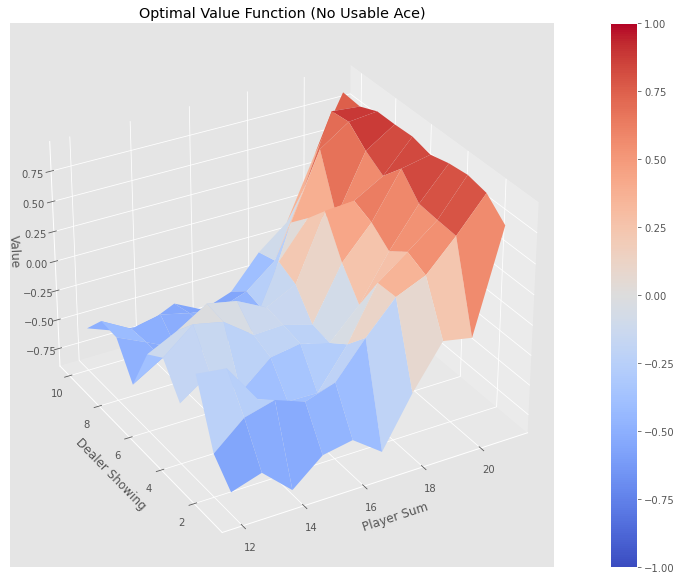

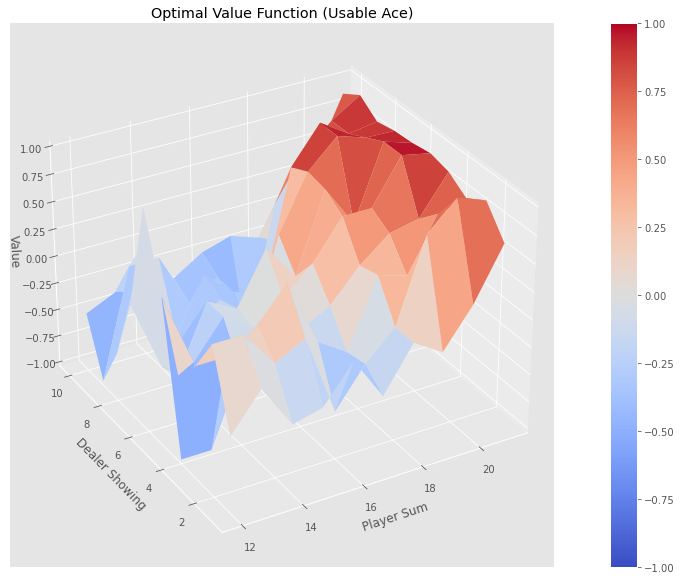

Performance at time steps: 50000
Exploration schedule: 1
Epsilon: 0.9
Running e-greedy policy: 100 times.

With usable aces:
mean:  -0.08333333333333333
min:  -1
max:  1
std:  0.9537935951882996

Without usable aces:
mean:  -0.48863636363636365
min:  -1
max:  1
std:  0.8659508460464688


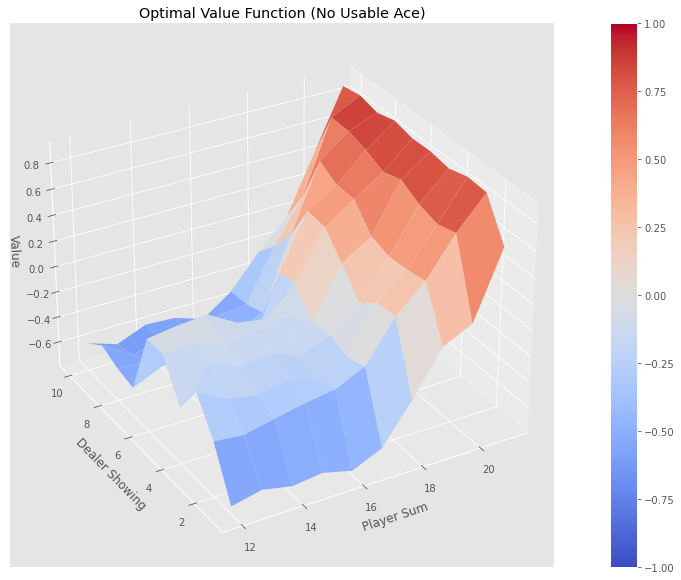

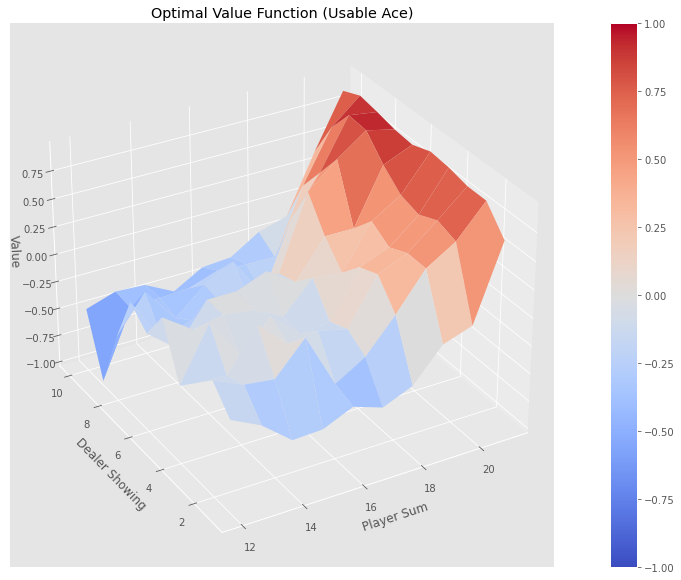

Performance at time steps: 100000
Exploration schedule: 1
Epsilon: 0.8
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.3333333333333333
min:  -1
max:  1
std:  0.9428090415820634

Without usable aces:
mean:  -0.2553191489361702
min:  -1
max:  1
std:  0.933264348913247


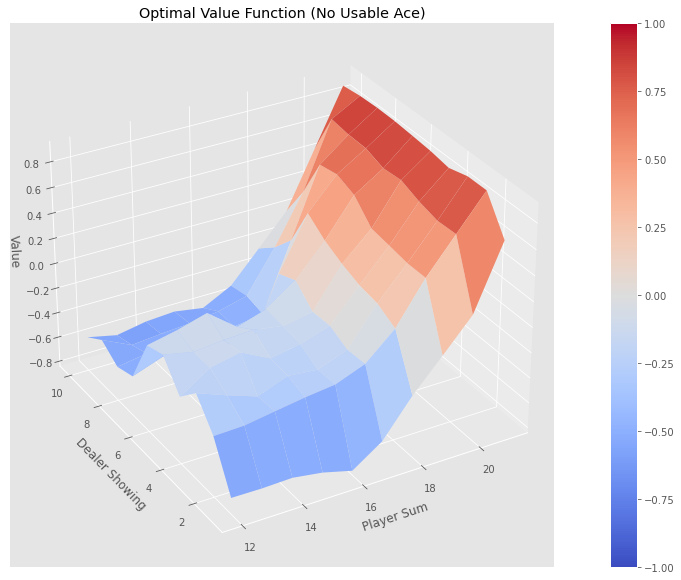

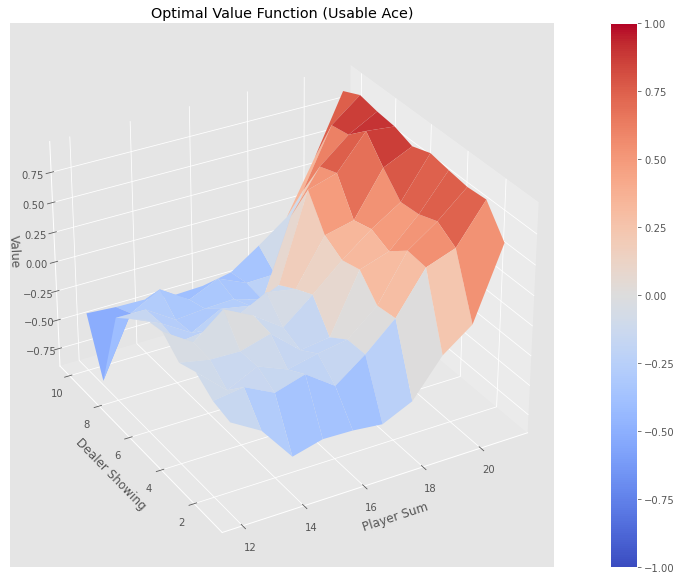

Performance at time steps: 300000
Exploration schedule: 1
Epsilon: 0.4
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.36363636363636365
min:  -1
max:  1
std:  0.8813963377120598

Without usable aces:
mean:  -0.42696629213483145
min:  -1
max:  1
std:  0.8854331822402491


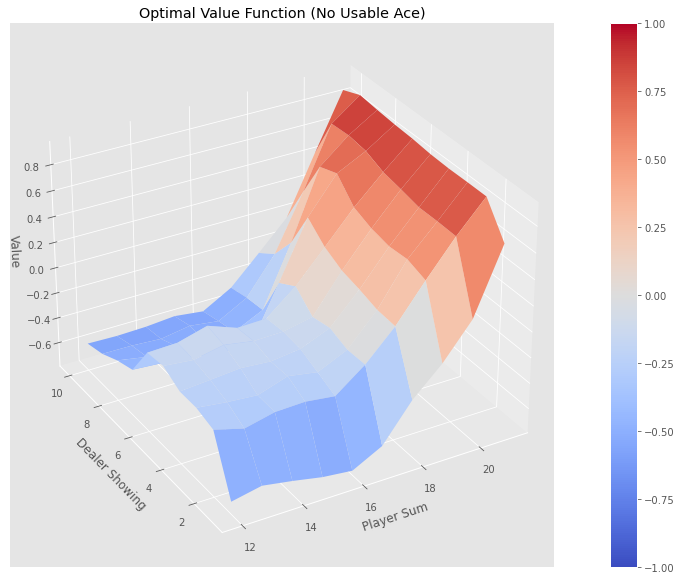

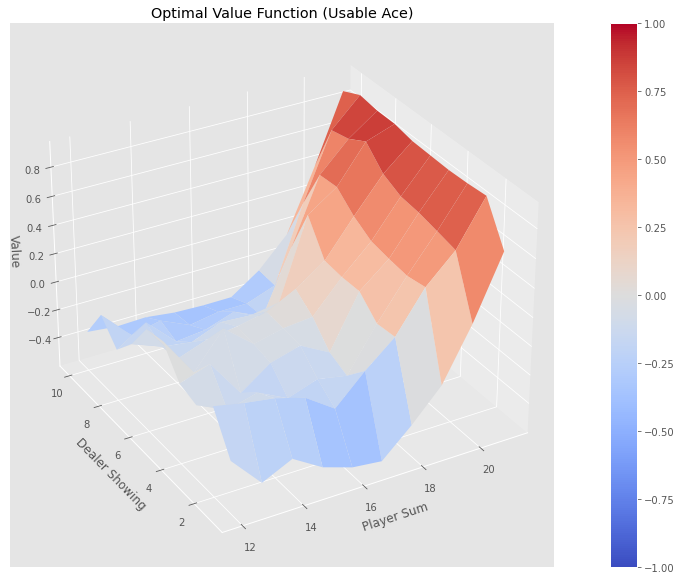

Performance at time steps: 400000
Exploration schedule: 1
Epsilon: 0.2
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.6363636363636364
min:  -1
max:  1
std:  0.77138921583987

Without usable aces:
mean:  -0.21348314606741572
min:  -1
max:  1
std:  0.9418116669526237


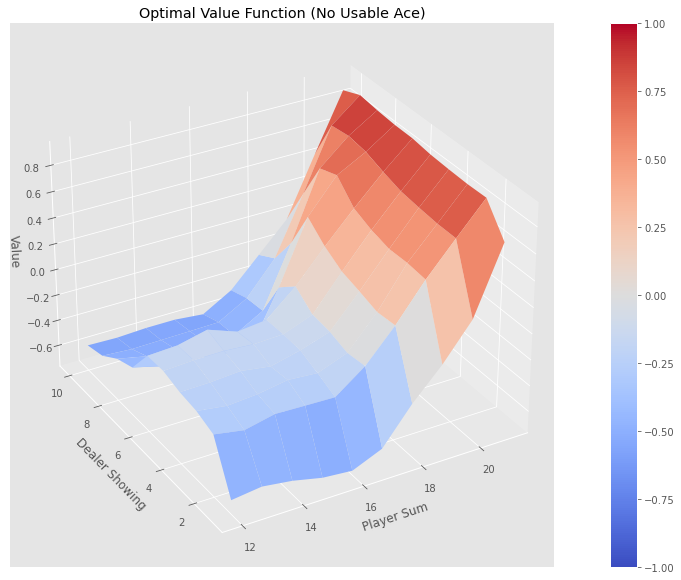

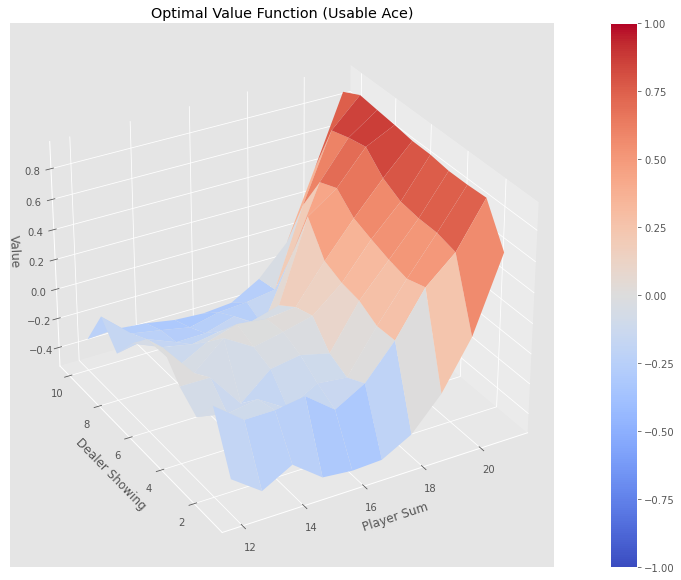

Performance at time steps: 500000
Exploration schedule: 1
Epsilon: 0.0
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.0
min:  -1
max:  1
std:  0.9534625892455924

Without usable aces:
mean:  -0.10112359550561797
min:  -1
max:  1
std:  0.9720237642194233


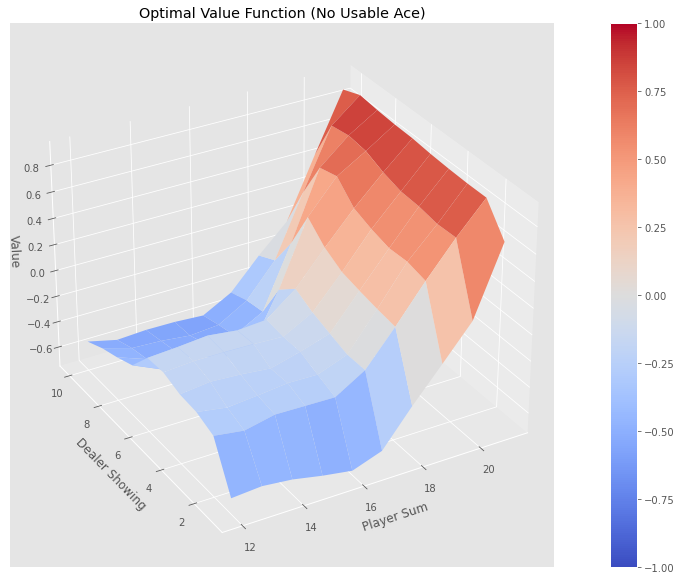

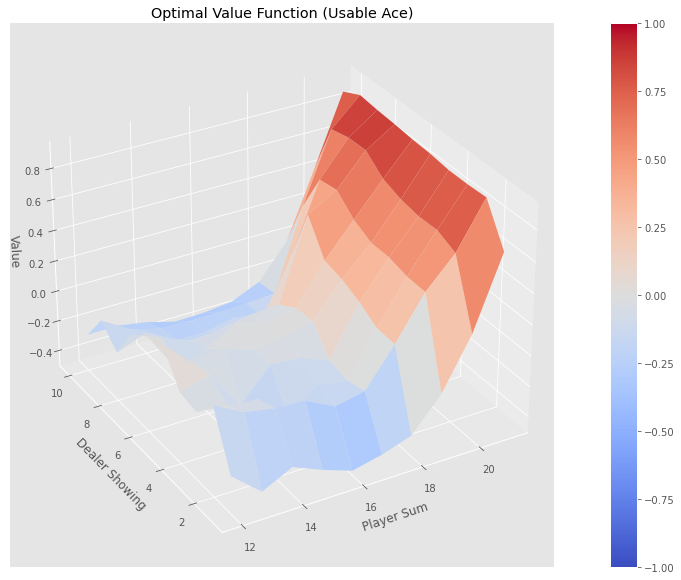

/home/nabil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  after removing the cwd from sys.path.
/home/nabil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  import sys



 64.53646700000013 s
Performance at time steps: 10000
Exploration schedule: 2
Epsilon: 0.09090909090909091
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.16666666666666666
min:  -1
max:  1
std:  0.8975274678557508

Without usable aces:
mean:  -0.056818181818181816
min:  -1
max:  1
std:  0.981162975822043


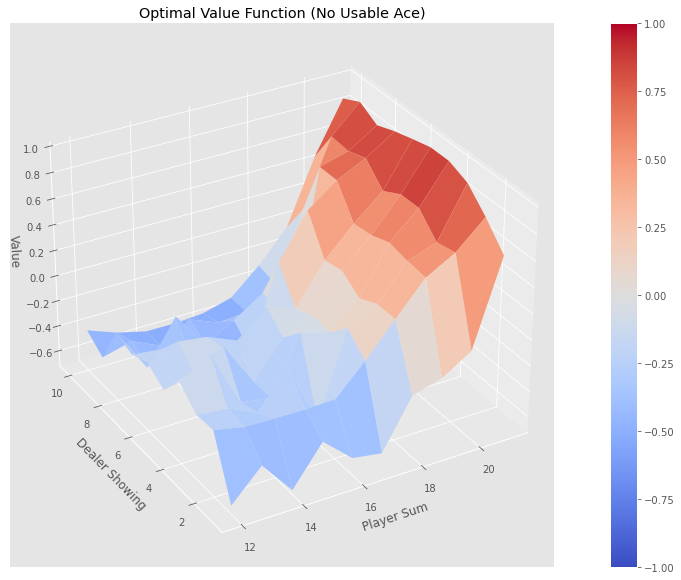

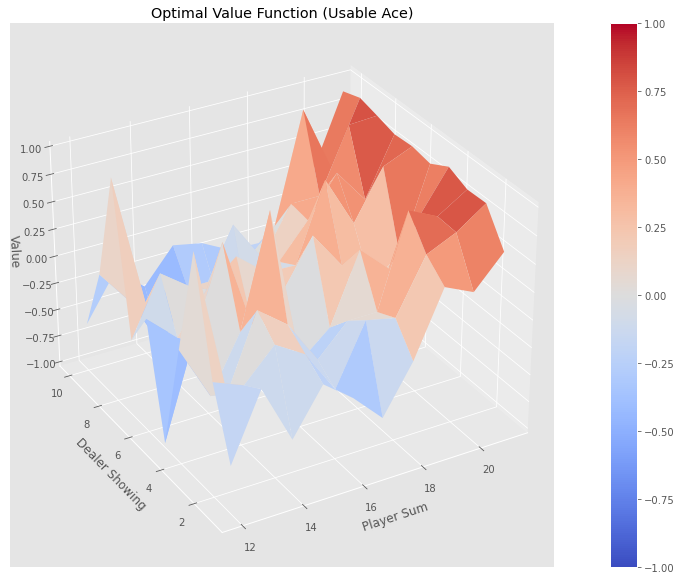

Performance at time steps: 50000
Exploration schedule: 2
Epsilon: 0.0196078431372549
Running e-greedy policy: 100 times.

With usable aces:
mean:  -0.2
min:  -1
max:  1
std:  0.9797958971132713

Without usable aces:
mean:  -0.3368421052631579
min:  -1
max:  1
std:  0.9246396318314842


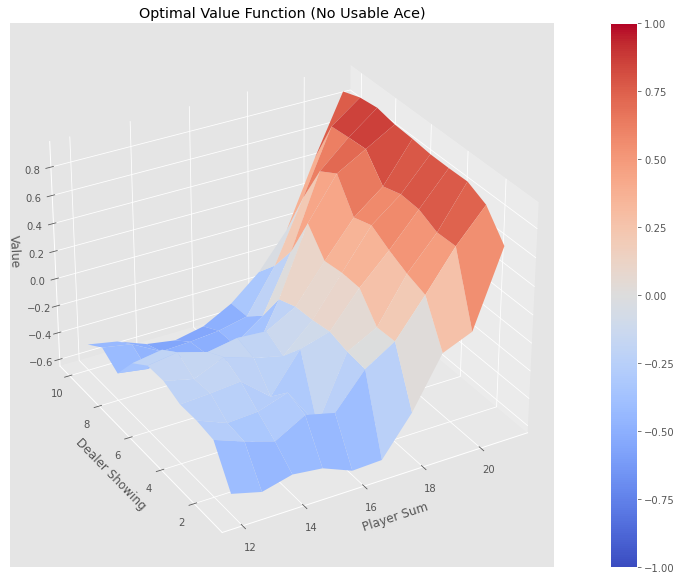

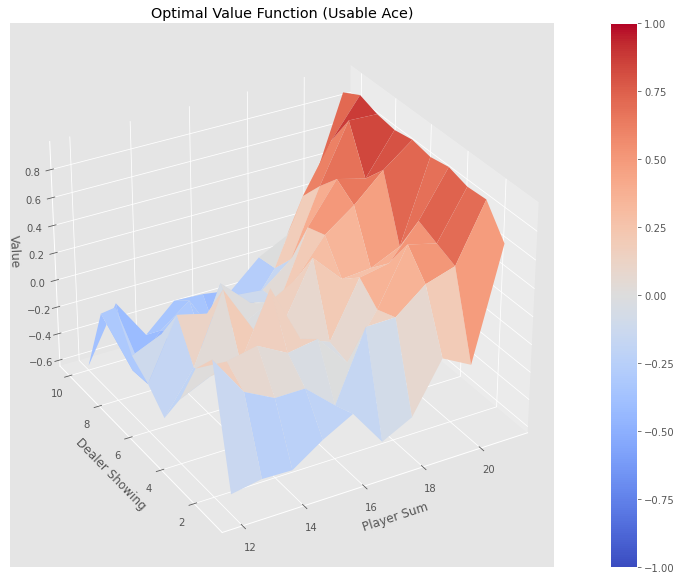

Performance at time steps: 100000
Exploration schedule: 2
Epsilon: 0.009900990099009901
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.8333333333333334
min:  0
max:  1
std:  0.3726779962499649

Without usable aces:
mean:  -0.1590909090909091
min:  -1
max:  1
std:  0.9400962672702925


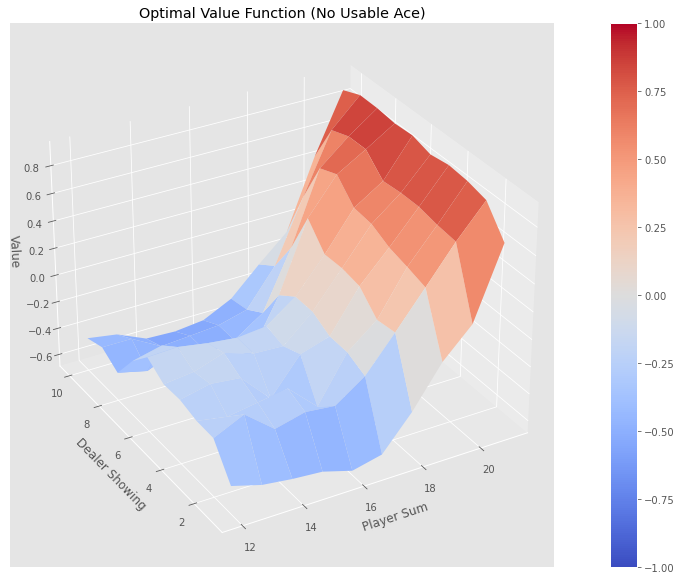

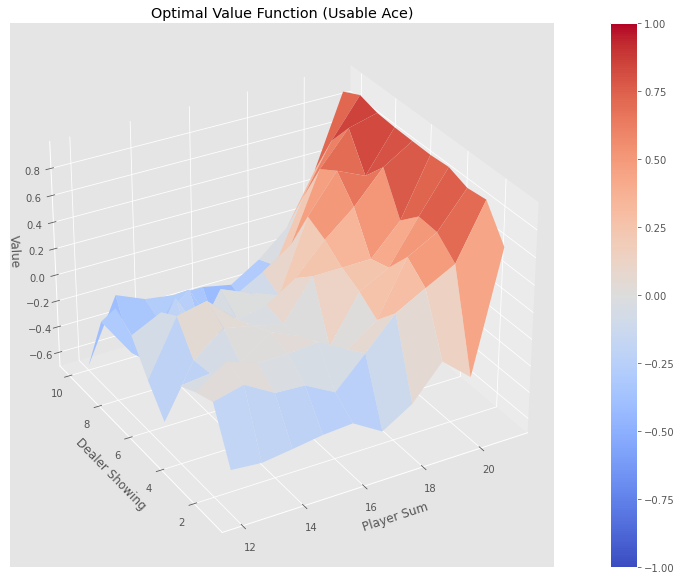

Performance at time steps: 300000
Exploration schedule: 2
Epsilon: 0.0033222591362126247
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.4
min:  -1
max:  1
std:  0.8

Without usable aces:
mean:  -0.2
min:  -1
max:  1
std:  0.9305279968604795


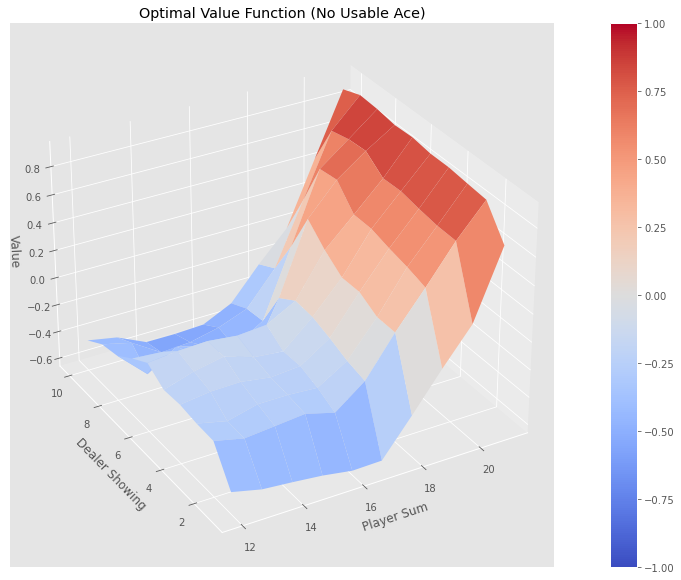

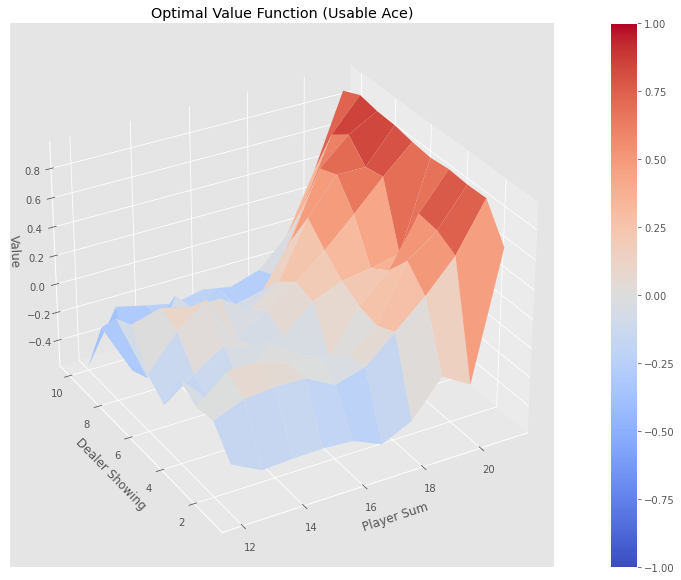

Performance at time steps: 400000
Exploration schedule: 2
Epsilon: 0.0024937655860349127
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.4
min:  -1
max:  1
std:  0.8793937305515279

Without usable aces:
mean:  -0.16470588235294117
min:  -1
max:  1
std:  0.9436731590661399


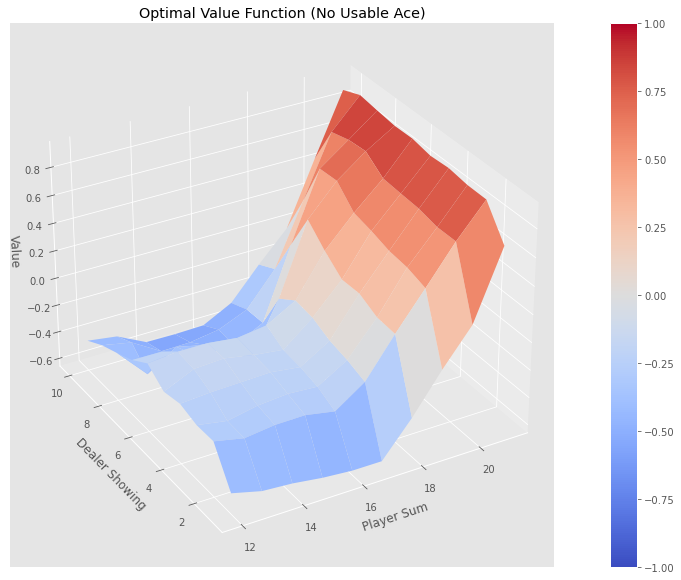

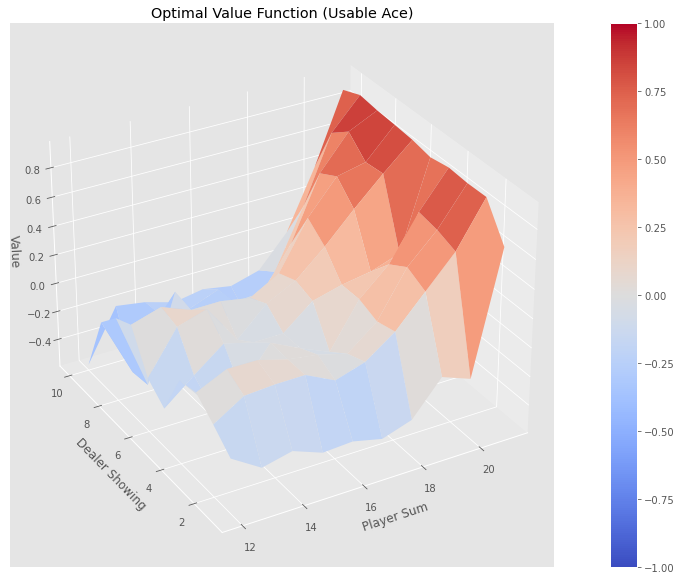

Performance at time steps: 500000
Exploration schedule: 2
Epsilon: 0.001996007984031936
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.0
min:  -1
max:  1
std:  0.9428090415820634

Without usable aces:
mean:  -0.23076923076923078
min:  -1
max:  1
std:  0.9267326875739788


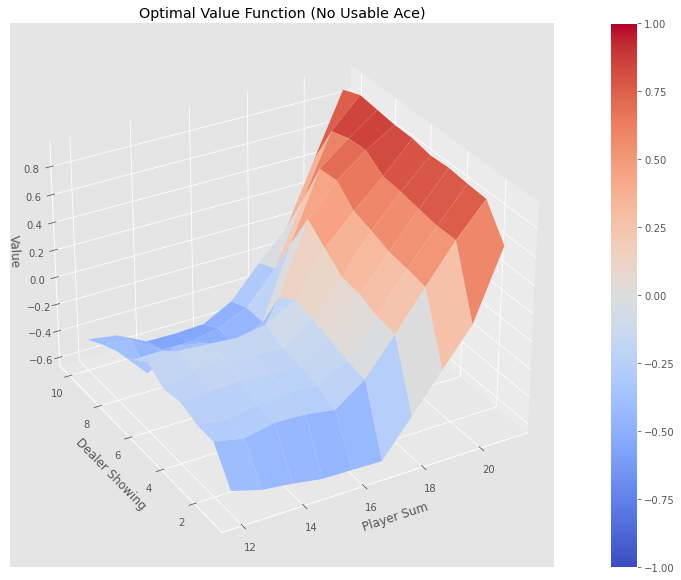

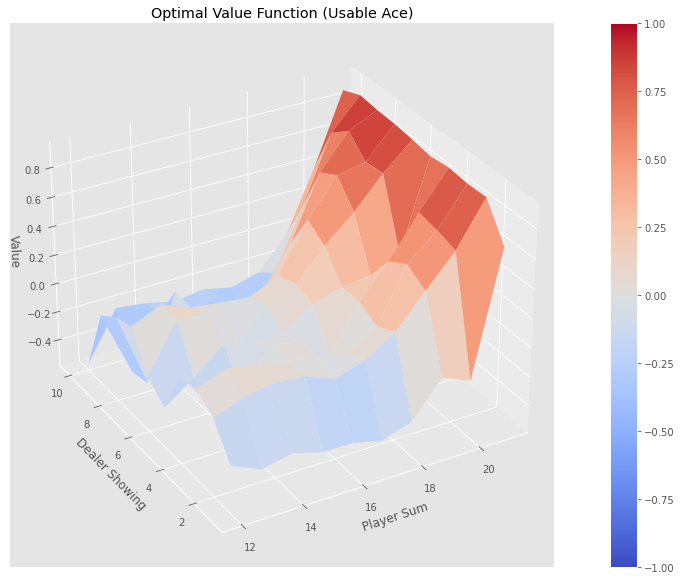

/home/nabil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if __name__ == '__main__':
/home/nabil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  if sys.path[0] == '':



 64.91029600000002 s
Performance at time steps: 10000
Exploration schedule: 3
Epsilon: 0.0001
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.3333333333333333
min:  -1
max:  1
std:  0.8498365855987975

Without usable aces:
mean:  -0.20454545454545456
min:  -1
max:  1
std:  0.9433871627507846


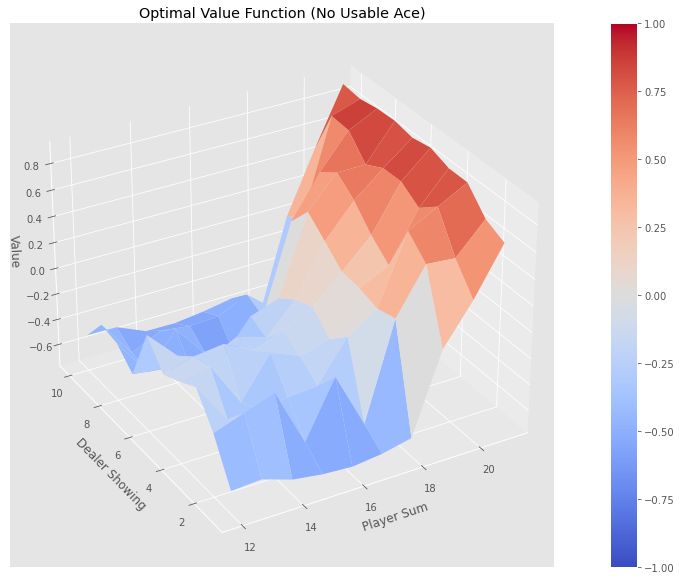

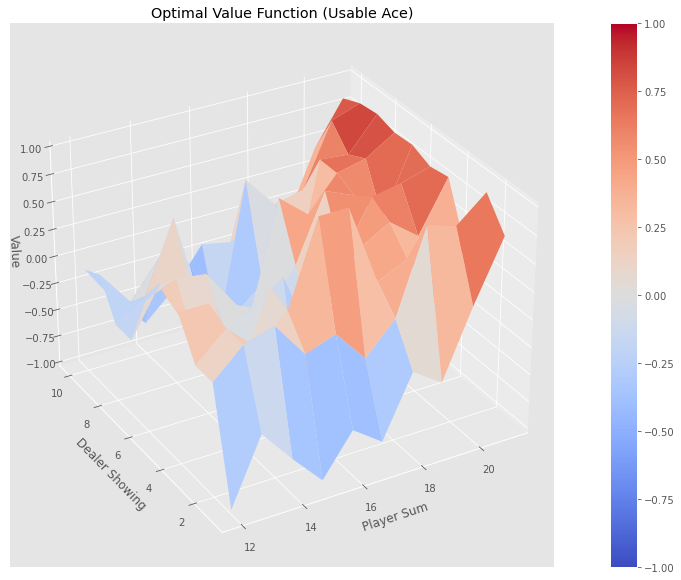

Performance at time steps: 50000
Exploration schedule: 3
Epsilon: 2e-05
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.4375
min:  -1
max:  1
std:  0.7880950133074057

Without usable aces:
mean:  -0.14285714285714285
min:  -1
max:  1
std:  0.9404008408634048


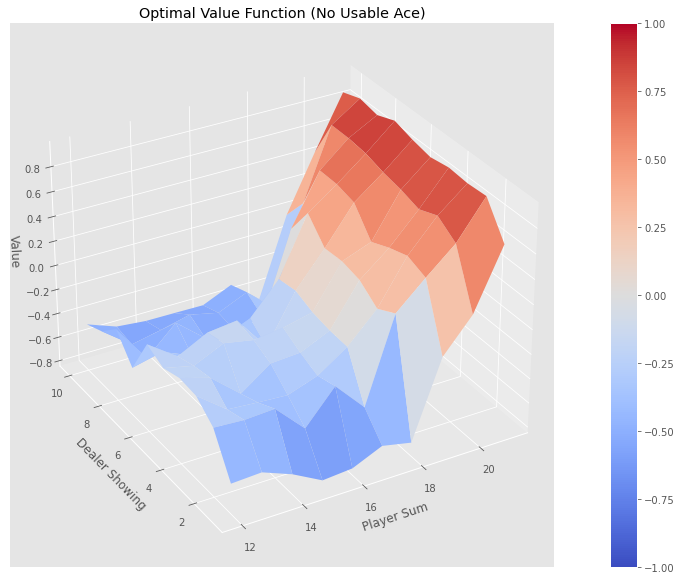

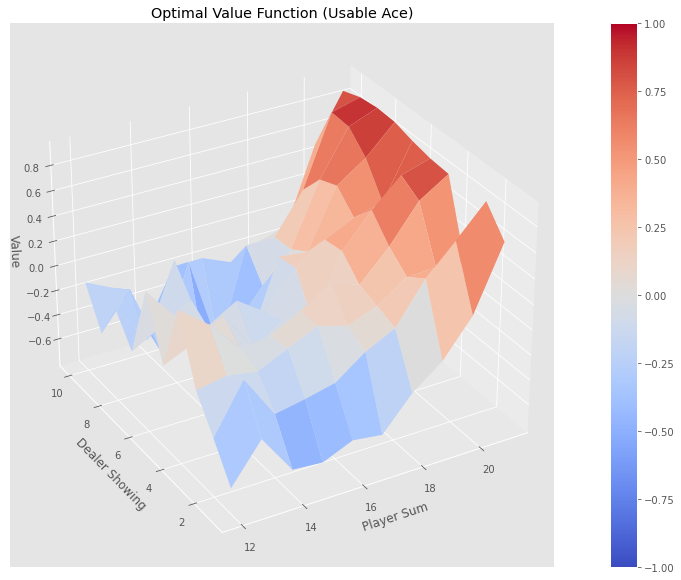

Performance at time steps: 100000
Exploration schedule: 3
Epsilon: 1e-05
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.5333333333333333
min:  -1
max:  1
std:  0.7180219742846006

Without usable aces:
mean:  -0.23529411764705882
min:  -1
max:  1
std:  0.9411764705882353


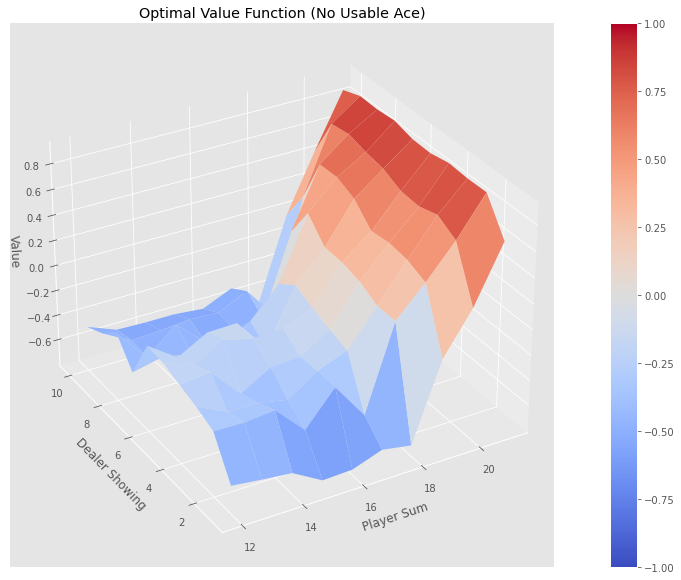

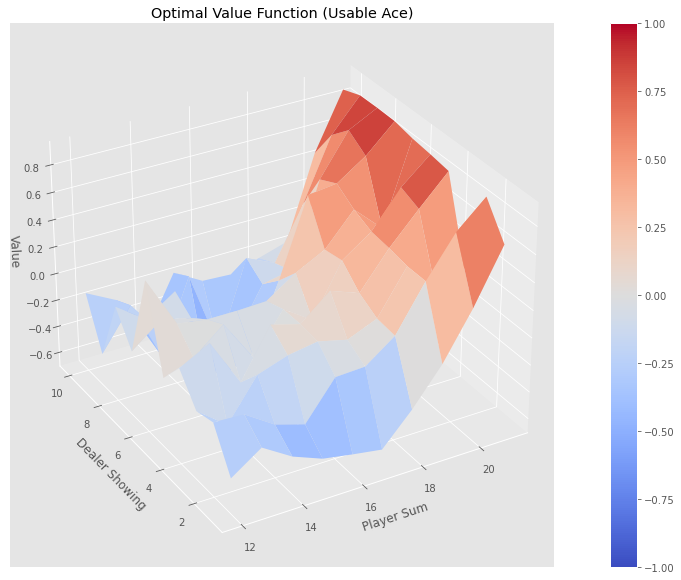

Performance at time steps: 300000
Exploration schedule: 3
Epsilon: 3.3333333333333333e-06
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.6
min:  -1
max:  1
std:  0.8000000000000002

Without usable aces:
mean:  -0.3111111111111111
min:  -1
max:  1
std:  0.914627361211408


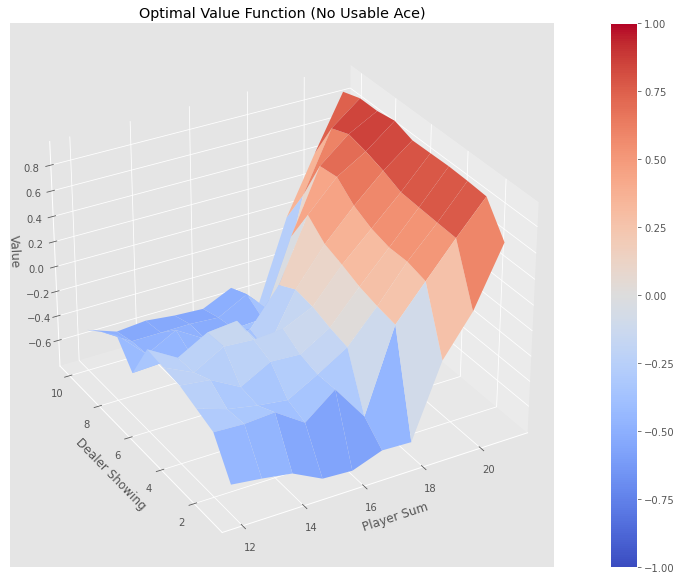

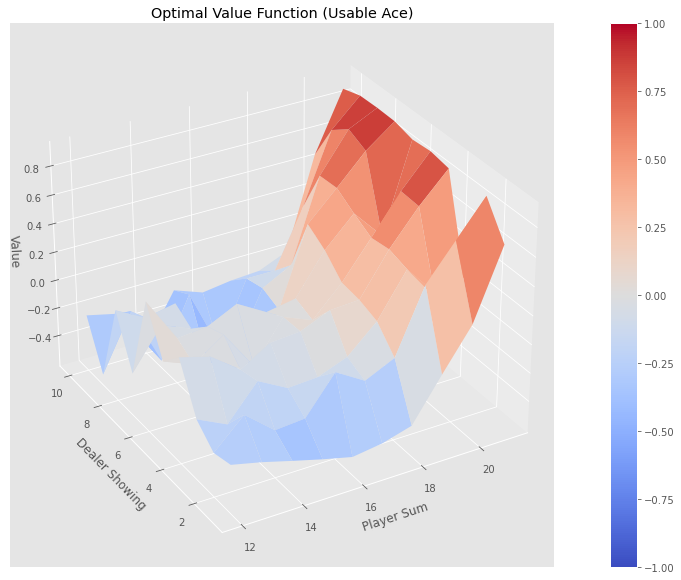

Performance at time steps: 400000
Exploration schedule: 3
Epsilon: 2.5e-06
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.5263157894736842
min:  -1
max:  1
std:  0.7517293082676684

Without usable aces:
mean:  -0.09876543209876543
min:  -1
max:  1
std:  0.9635958667203881


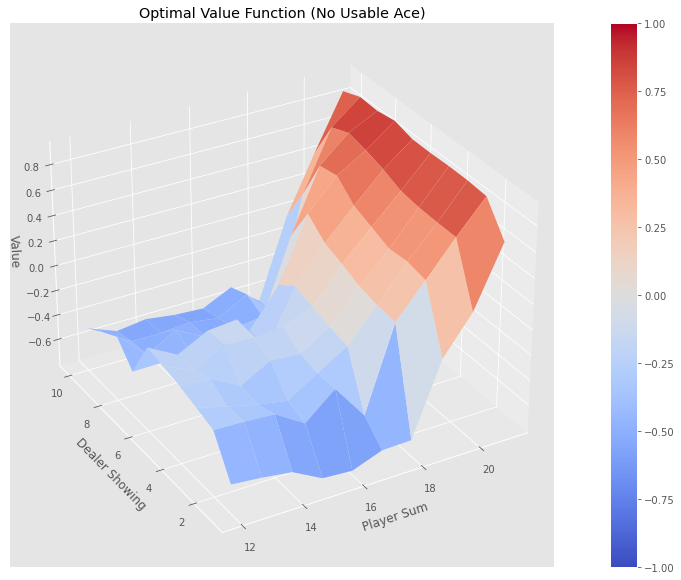

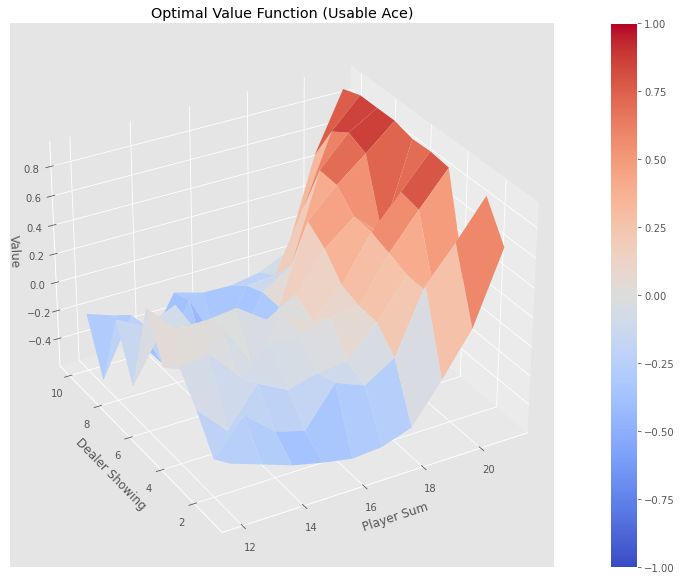

Performance at time steps: 500000
Exploration schedule: 3
Epsilon: 2e-06
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.4
min:  -1
max:  1
std:  0.9165151389911681

Without usable aces:
mean:  -0.18888888888888888
min:  -1
max:  1
std:  0.9648770151273103


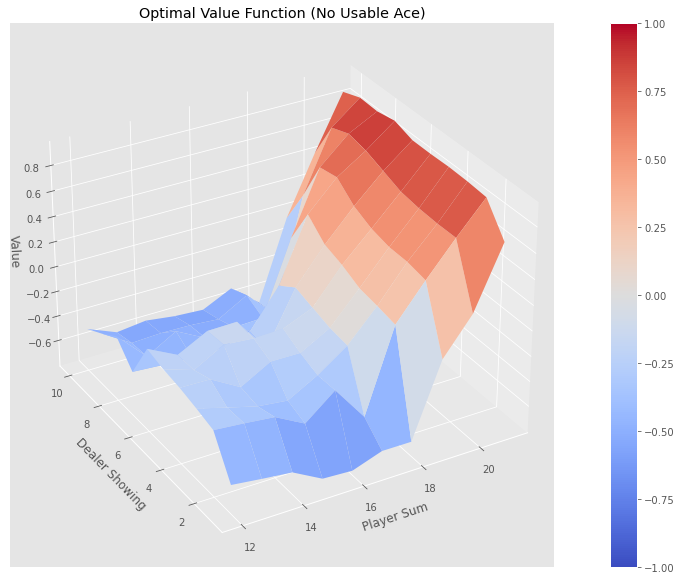

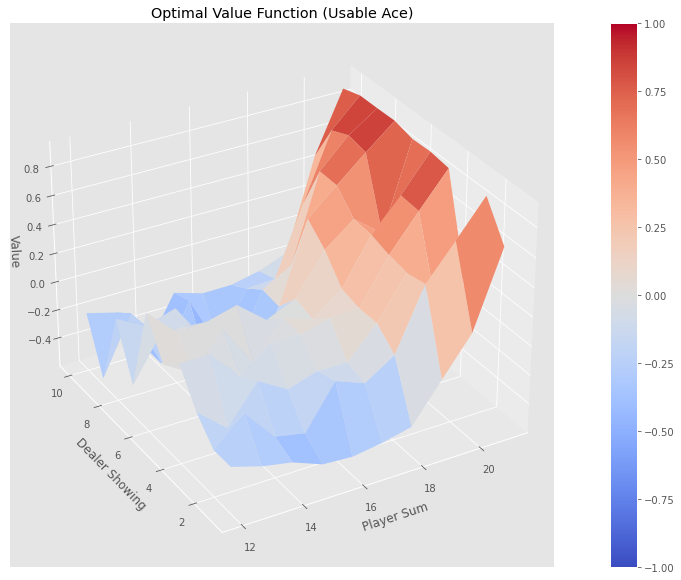

/home/nabil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  
/home/nabil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead



 64.60634700000014 s
Performance at time steps: 10000
Exploration schedule: 4
Epsilon: 0.1
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.5
min:  -1
max:  1
std:  0.8660254037844386

Without usable aces:
mean:  -0.2857142857142857
min:  -1
max:  1
std:  0.8806305718527108


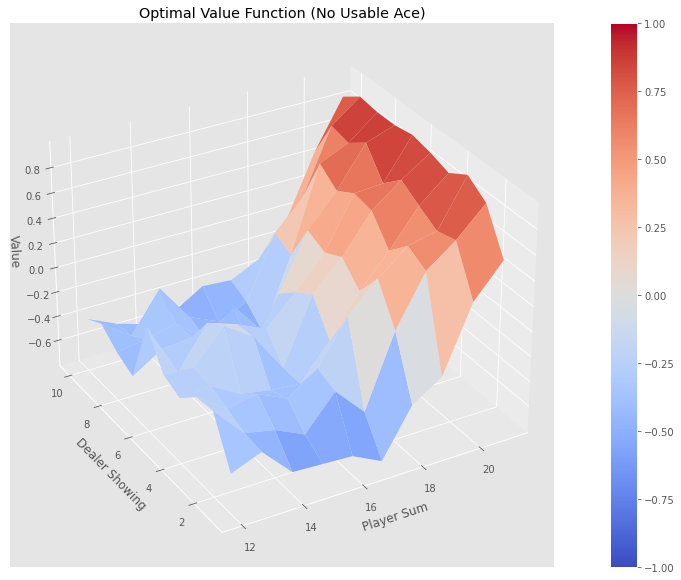

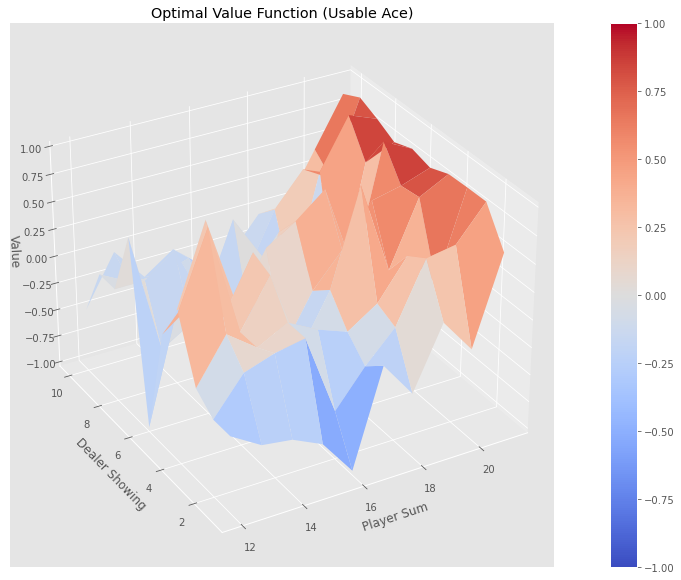

Performance at time steps: 50000
Exploration schedule: 4
Epsilon: 1.0000000000000027e-50
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.21428571428571427
min:  -1
max:  1
std:  0.9394961741404217

Without usable aces:
mean:  -0.10465116279069768
min:  -1
max:  1
std:  0.9527081322678765


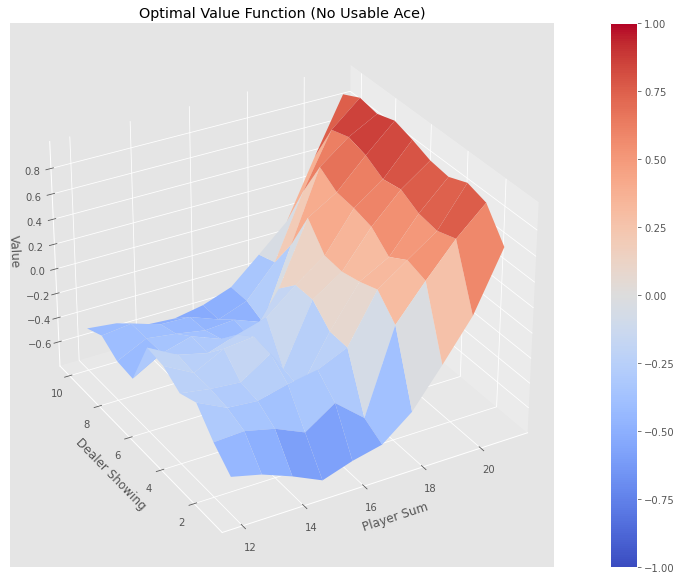

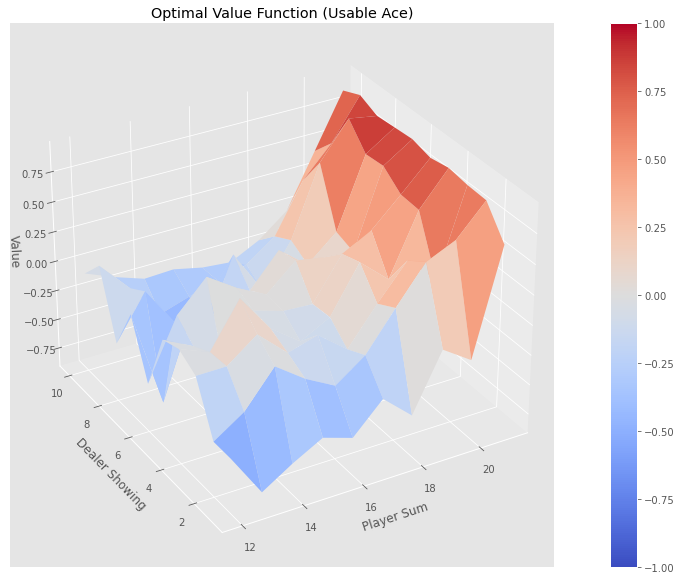

Performance at time steps: 100000
Exploration schedule: 4
Epsilon: 1.0000000000000056e-100
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.16666666666666666
min:  -1
max:  1
std:  0.9860132971832694

Without usable aces:
mean:  -0.10227272727272728
min:  -1
max:  1
std:  0.965775391816346


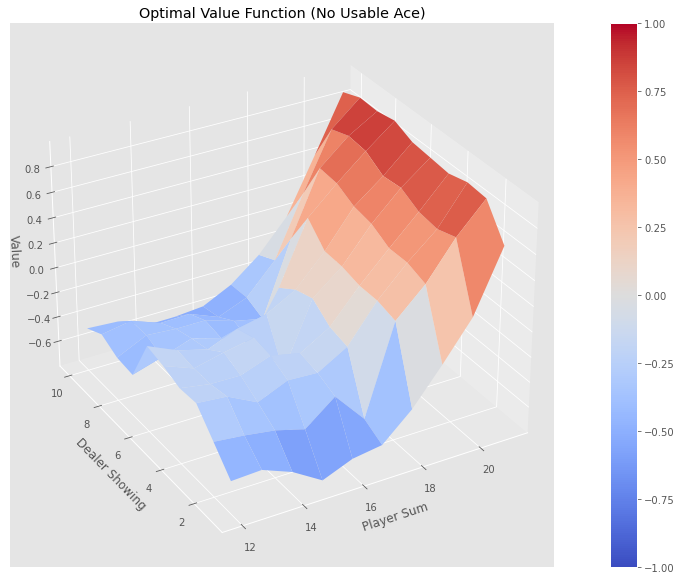

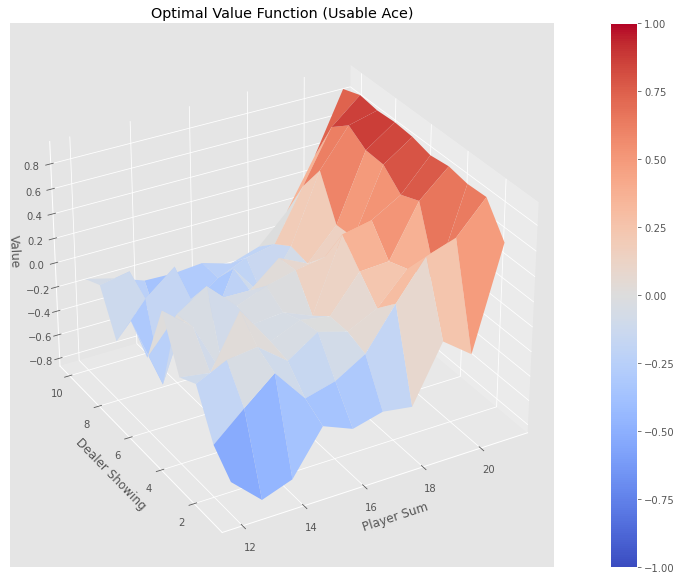

Performance at time steps: 300000
Exploration schedule: 4
Epsilon: 1.0000000000000166e-300
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.3333333333333333
min:  -1
max:  1
std:  0.8498365855987975

Without usable aces:
mean:  -0.09090909090909091
min:  -1
max:  1
std:  0.93706946036765


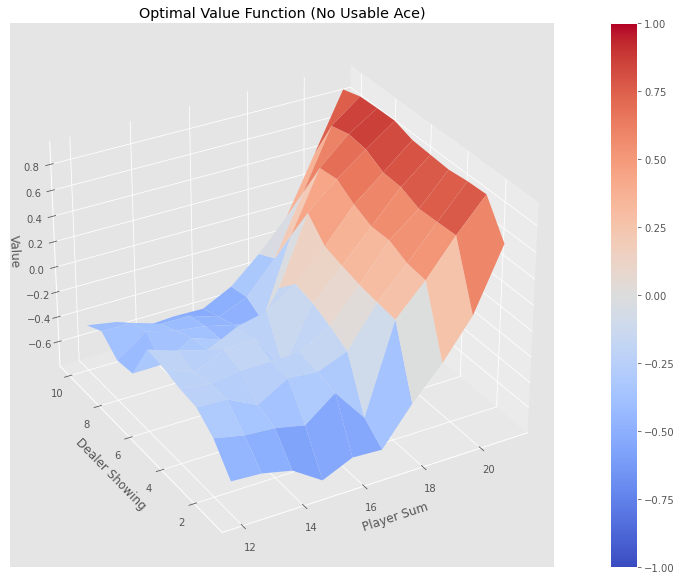

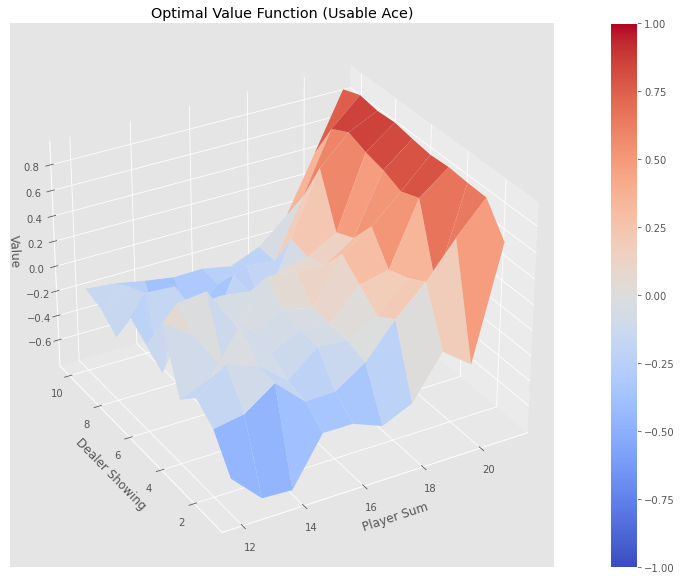

Performance at time steps: 400000
Exploration schedule: 4
Epsilon: 0.0
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.15384615384615385
min:  -1
max:  1
std:  0.9483713850721502

Without usable aces:
mean:  -0.2988505747126437
min:  -1
max:  1
std:  0.9111687900048927


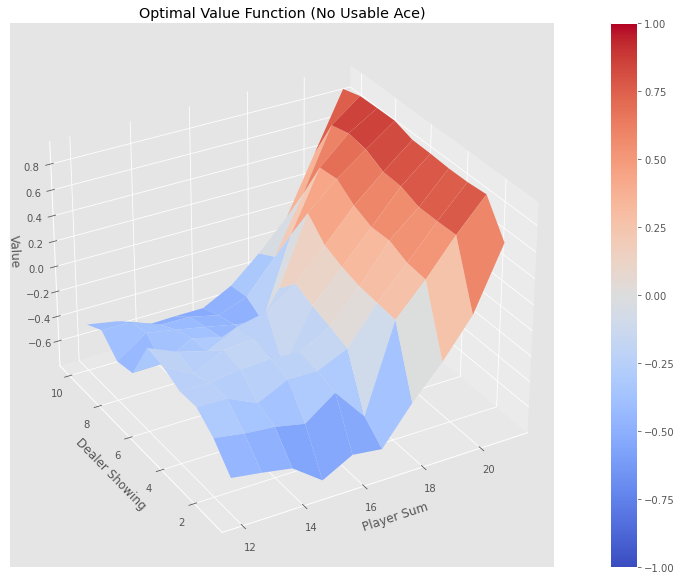

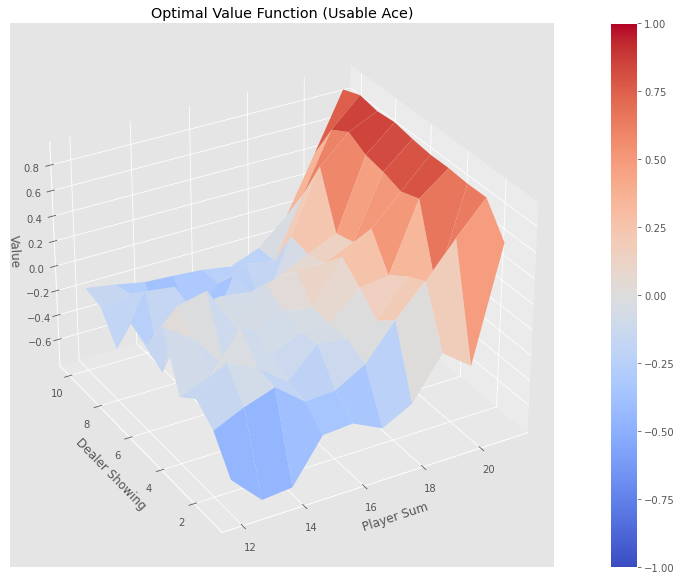

Performance at time steps: 500000
Exploration schedule: 4
Epsilon: 0.0
Running e-greedy policy: 100 times.

With usable aces:
mean:  0.625
min:  -1
max:  1
std:  0.6959705453537527

Without usable aces:
mean:  -0.16304347826086957
min:  -1
max:  1
std:  0.9357300557533009


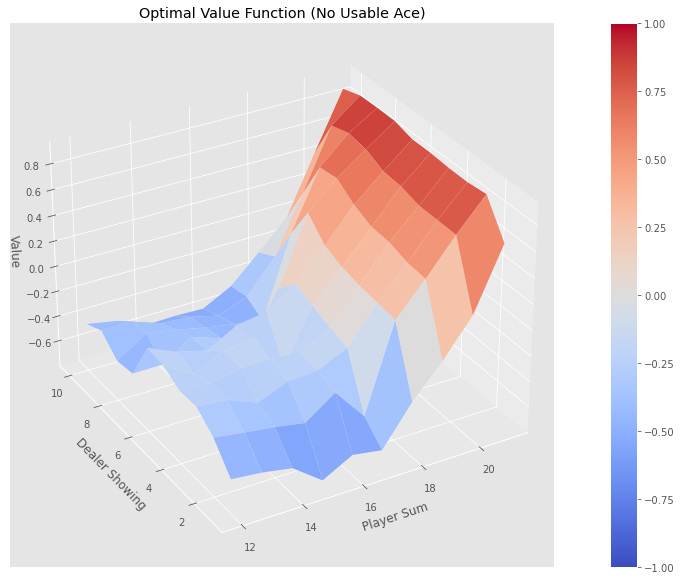

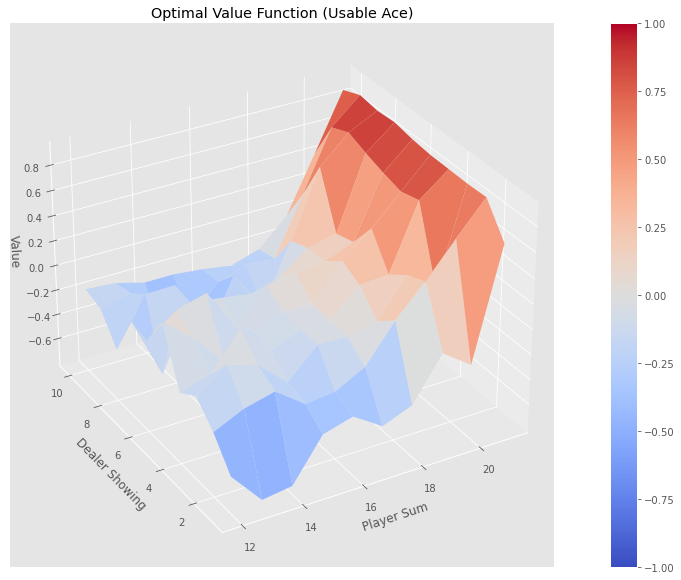


 66.24256300000002 s


/home/nabil/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead


In [138]:
# Task 2 - 2 - 4 : for at least two exploration schedules, incl. your best one.
start = time.clock()
Q1, policy1, rewards1 = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=1)
end = time.clock()
print("\n",end - start,"s")

start = time.clock()
Q2, policy2, rewards2 = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=2)
end = time.clock()
print("\n",end - start,"s")

start = time.clock()
Q3, policy3, rewards3 = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=3)
end = time.clock()
print("\n",end - start,"s")

start = time.clock()
Q4, policy4, rewards4 = mc_control_epsilon_greedy(env, num_episodes=500000, epsilon=4)
end = time.clock()
print("\n",end - start,"s")

In [139]:
import matplotlib.pyplot as plt

def plot_av_rewards(rewards1 , rewards2, rewards3, rewards4):
#     plt.plot([0.5 for _ in range(500000)], linestyle="--")
    plt.plot([10000, 50000, 100000, 300000, 400000, 500000], rewards1, color='mediumvioletred')
    plt.plot([10000, 50000, 100000, 300000, 400000, 500000], rewards2, color='orange')
    plt.plot([10000, 50000, 100000, 300000, 400000, 500000], rewards3, color='green')
    plt.plot([10000, 50000, 100000, 300000, 400000, 500000], rewards4, color='blue')
    plt.title("Average Reward of GLIE Epsilon-Greedy Agent")
    plt.legend(("Exploration schedule 1", "Exploration schedule 2", 
                "Exploration schedule 3", "Exploration schedule 4"), loc="lower right")
    plt.xlabel("Steps")
    plt.ylabel("Average reward")
    plt.show()

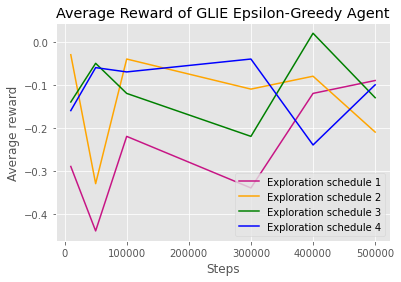

In [140]:
# plotting the rewards
plot_av_rewards(rewards1, rewards2, rewards3, rewards4)

In [142]:
print("mean sch1: ", np.mean(rewards1))
print("mean sch2: ", np.mean(rewards2))
print("mean sch3: ", np.mean(rewards3))
print("mean sch4: ", np.mean(rewards4))

mean sch1:  -0.25000000000000006
mean sch2:  -0.13333333333333333
mean sch3:  -0.10666666666666667
mean sch4:  -0.11166666666666668


In [143]:
def analyse(Q):
    P = defaultdict(float)
    for state, actions in Q.items():
        action = np.argmax(actions)
        P[state] = action
    return P

In [144]:
P1 = analyse(Q1)
P2 = analyse(Q2)
P3 = analyse(Q3)
P4 = analyse(Q4)

In [145]:
accuracy_12 = 0
accuracy_13 = 0
accuracy_14 = 0
accuracy_23 = 0
accuracy_24 = 0
accuracy_34 = 0
for state in P1.keys():
    accuracy_12 += P1[state] == P2[state]
    accuracy_13 += P1[state] == P3[state]
    accuracy_14 += P1[state] == P4[state]
    accuracy_23 += P2[state] == P3[state]
    accuracy_24 += P2[state] == P4[state]
    accuracy_34 += P3[state] == P4[state]
    
accuracy_12 /= 200
accuracy_13 /= 200
accuracy_14 /= 200
accuracy_23 /= 200
accuracy_24 /= 200
accuracy_34 /= 200

In [146]:
print("accuracy_12 :", accuracy_12)
print("accuracy_13 :", accuracy_13)
print("accuracy_14 :", accuracy_14)
print("accuracy_23 :", accuracy_23)
print("accuracy_24 :", accuracy_24)
print("accuracy_34 :", accuracy_34)

accuracy_12 : 0.86
accuracy_13 : 0.75
accuracy_14 : 0.7
accuracy_23 : 0.68
accuracy_24 : 0.7
accuracy_34 : 0.64


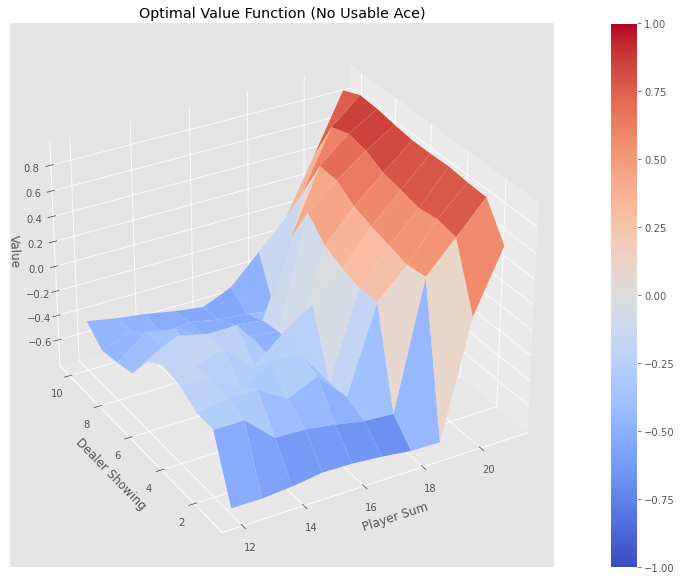

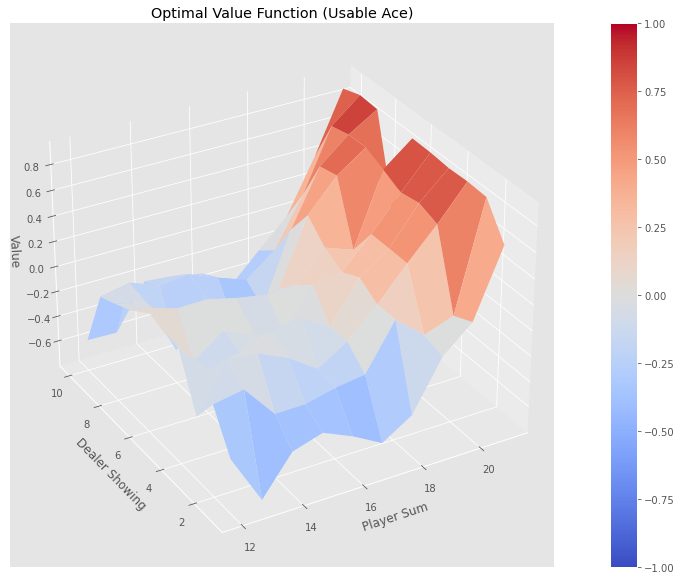

In [53]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value

    plotting.plot_value_function(V, title="Optimal Value Function")